In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "darkgrid")

c:\Users\bapti\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bapti\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\bapti\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## Chargement du dataset et analyse

### Chargement des datasets et merge

In [2]:
tourisme_dataset = pd.read_csv("C:/Users/bapti/Desktop/Projet Data Mining/data/base-cc-tourisme-2022-geo2022-CSV/base-cc-tourisme-2022-geo2022.csv", 
                               encoding='utf8',
                               delimiter=";",
                               low_memory=False)
population_dataset = pd.read_excel("C:/Users/bapti/Desktop/Projet Data Mining/data/base-pop-historiques-1876-2019.xlsx")
print(f"Datasets fusionnable sur les colonnes : {*[x for x in population_dataset.columns if x in tourisme_dataset.columns],}")
merged_df = tourisme_dataset.merge(population_dataset, on = "CODGEO", how = "inner")

Datasets fusionnable sur les colonnes : ('CODGEO',)


### Analyse des outliers

In [3]:
from src.tools import remove_outliers

On considère toutes les valeurs supérieurs au 9e décile comme des outliers. C'est une solution extrême, mais motivée par le fait que de nombreuses valeurs sont très détachées du reste des points, ce qui écrase fortement la distribution.

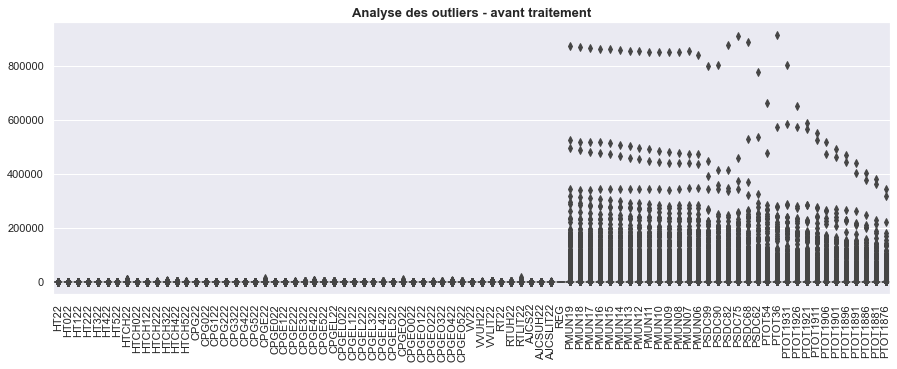

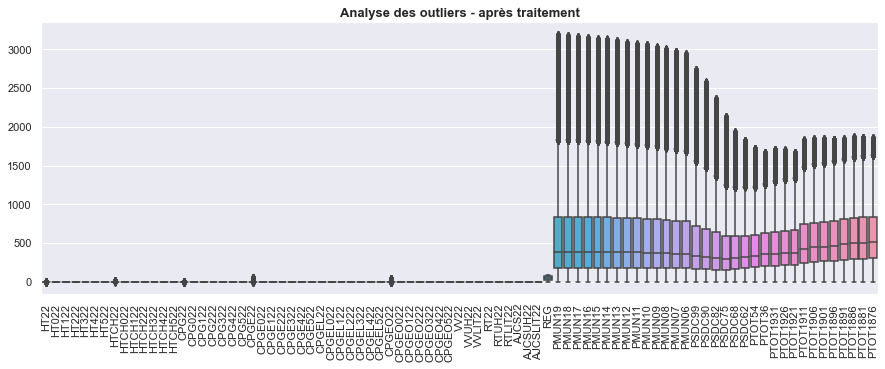

In [4]:
merged_df = remove_outliers(merged_df, merged_df.select_dtypes(include = np.number).columns.tolist(), seuil = .90)

### Analyse des valeurs manquantes

In [5]:
from src.tools import visualize_nan

Shape : (34957, 88)


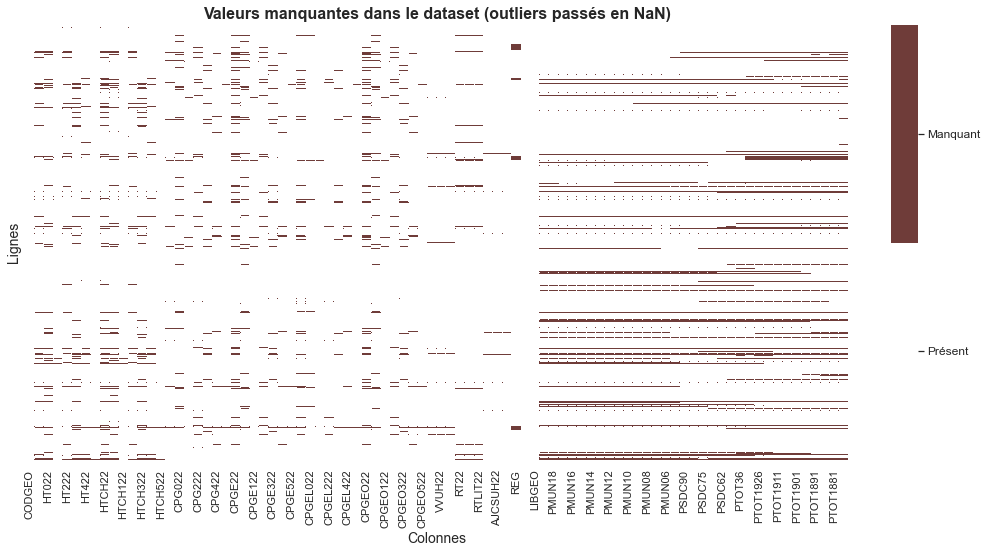

In [6]:
visualize_nan(merged_df, "Valeurs manquantes dans le dataset (outliers passés en NaN)")

In [7]:
print(f"{merged_df.select_dtypes(include = np.number).shape[1]} colonnes numériques dans le jeu de données sur {merged_df.shape[1]}.")

85 colonnes numériques dans le jeu de données sur 88.


### Imputation des valeurs manquantes

De par le fort nombre de variables numériques, il peut être pertinent d'imputer les variables par les K plus proches voisins. Cette technique se basant sur des distances, avoir un grand nombre de variables numériques permet de proposer une imputation intéressante.

In [8]:
from sklearn.impute import KNNImputer
# TESTER LE NOMBRE OPTIMAL DE VOISINS

In [9]:
# from src.tools import find_best_knn
# #### Long à faire tourner
# best_choice = find_best_knn(merged_df, merged_df.select_dtypes(include = float).columns)

# imputer = KNNImputer(n_neighbors=best_choice)
# merged_df[merged_df.select_dtypes(include = np.number).columns] = imputer.fit_transform(merged_df.select_dtypes(include = np.number))

In [10]:
# Pour comparer les statistiques du jeu de données avant et après imputation
description = merged_df.select_dtypes(include = np.number).describe()

In [11]:
imputer = KNNImputer(n_neighbors=5)
merged_df[merged_df.select_dtypes(include = np.number).columns] = imputer.fit_transform(merged_df.select_dtypes(include = np.number))

In [12]:
print(f'{merged_df.isna().sum().sum()} variables manquantes restantes après imputation')

0 variables manquantes restantes après imputation


In [13]:
description = merged_df.select_dtypes(include = float).describe()
# La moyenne, la variance ainsi que les quantiles sont très légérements impactés par l'imputation des valeurs manquantes

### Analyse des corrélations

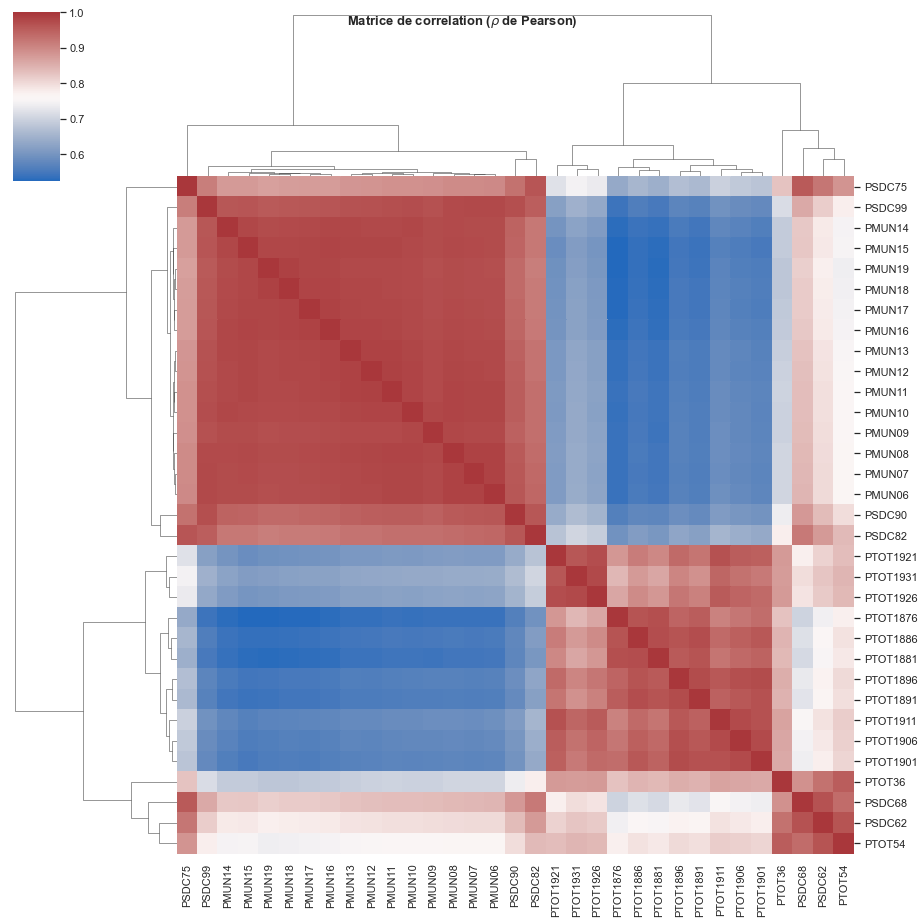

In [14]:
g = sns.clustermap(merged_df.loc[:, [x for x in merged_df.columns if 'PM' in x or 'PS' in x or 'PTOT' in x]].corr().fillna(0), cmap='vlag', cbar_kws={"shrink": .5}, figsize = (13, 13))
g.fig.suptitle(r"Matrice de correlation ($\rho$ de Pearson)", fontsize = 13, fontweight = "bold")
_ = plt.show()

Les variables avec des préfixes similaires sont fortements corrélées notamment les variables relatives à la population. Cela fait sens, la population d'une ville à une période t est forcément liée à la population de cette même ville à une période t+1 (sauf cas de catastrophe).

Au vu des résultats, nous préssentons pour l'ACP que les axes seront représentatifs des groupes formés par les préfixes, et notamment les gros clusters de variables corrélés comme les variables de "PMUN" à "PTOT".

## Réduction de dimension (ACP)

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

On standardise les données pour leur donner une variance de 1 et une moyenne de 0. Cela permet d'éviter les problèmes dûes aux échelles différentes des variables.

In [16]:
sc = StandardScaler()
X_scaled = sc.fit_transform(merged_df.select_dtypes(include=np.number)) # Les variables qualitatives sont les libellés des villes et département
# Ils ne nous seront pas utiles dans l'ACP, en revanche nous les utiliserons après pour analyser les résultats

In [17]:
acp = PCA(n_components=15) # On veut deux composantes principales pour la visualisation
acp.fit(X_scaled)

PCA(n_components=15)

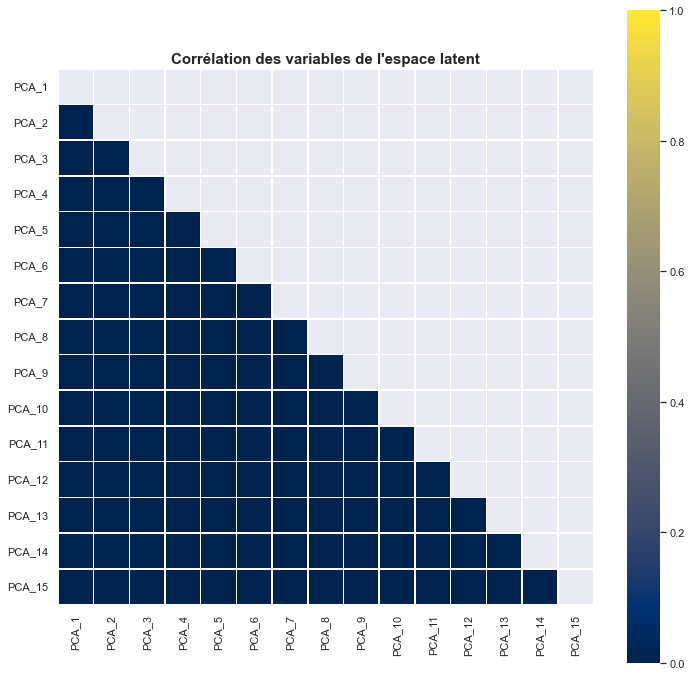

In [18]:
# Logiquement, la corrélation entre les variables de l'espace latent devrait être proche de 0
latent_space = acp.transform(X_scaled)

plt.figure(figsize=(12, 12))
plt.title("Corrélation des variables de l'espace latent", fontsize = 15, fontweight = "bold")
sns.heatmap(pd.DataFrame(latent_space, columns=["PCA_"+str(x) for x in np.arange(1, 16, 1)]).corr(),
            mask = np.triu(pd.DataFrame(latent_space, columns=["PCA_"+str(x) for x in np.arange(1, 16, 1)]).corr()),
            annot = False,
            square=True,
            linewidths=.5,
            vmin = 0,
            vmax = 1,
            cmap = "cividis")
_ = plt.show()

L'ACP à bien fonctionnée et les résultats sont cohérents (composantes principales non corrélées)

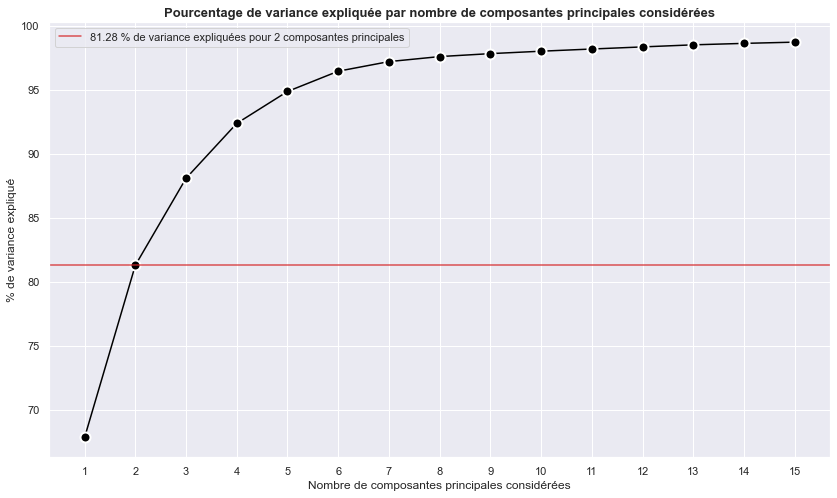

In [19]:
# On veut voir les % de variance expliquées 
plt.figure(figsize = (14, 8))
plt.title("Pourcentage de variance expliquée par nombre de composantes principales considérées", fontweight = "bold", fontsize = 13)
plt.plot([acp.explained_variance_ratio_[:i].sum() * 100 for i in range(1, 16, 1)], 
         marker = "o", 
         color = "black",
         markeredgewidth = 2, 
         markersize = 10,
         markeredgecolor = "white")
plt.axhline(y = acp.explained_variance_ratio_[:2].sum() * 100, label = f"{acp.explained_variance_ratio_[:2].sum() * 100:.2f} % de variance expliquées pour 2 composantes principales",
            color = "tab:red", 
            alpha = .8)
plt.ylabel("% de variance expliqué")
plt.xlabel("Nombre de composantes principales considérées")
plt.xticks(ticks = np.arange(0, 15, 1), labels=np.arange(1, 16, 1))
plt.legend()
plt.show()

In [20]:
print(f"2 composantes principales nous permettent d'expliquer {acp.explained_variance_ratio_[:2].sum() * 100:.2f}% de variance expliquée.")

2 composantes principales nous permettent d'expliquer 81.28% de variance expliquée.


In [21]:
# De quelles variables nos composantes principales sont explicatives ?
copied_df = merged_df.copy()
copied_df["PC1"] = latent_space[:, 0]; copied_df["PC2"] = latent_space[:, 1]
corr_pcs = copied_df.corr().filter(items = ["PC1", "PC2"], axis = 0).drop(labels = ["PC1", "PC2"], axis = 1).T

correlated_values_pc1 = [indexes for indexes in corr_pcs["PC1"].index if corr_pcs.loc[indexes, "PC1"] > 0.9] # Variables expliquées par la PC1
correlated_values_pc2 = [indexes for indexes in corr_pcs["PC2"].index if corr_pcs.loc[indexes, "PC2"] > 0.6] # Variables expliquées par la PC2
# La PC2 est moins fortement corréléé aux valeurs, on baisse le seuil

In [22]:
print("PC1 / variables représentatives (pearson 0.9) :", correlated_values_pc1)
print("\n")
print("PC2 / variables représentatives (pearson 0.6) :", correlated_values_pc2)

PC1 / variables représentatives (pearson 0.9) : ['PMUN19', 'PMUN18', 'PMUN17', 'PMUN16', 'PMUN15', 'PMUN14', 'PMUN13', 'PMUN12', 'PMUN11', 'PMUN10', 'PMUN09', 'PMUN08', 'PMUN07', 'PMUN06', 'PSDC99', 'PSDC90', 'PSDC82', 'PSDC75', 'PSDC68', 'PSDC62', 'PTOT54']


PC2 / variables représentatives (pearson 0.6) : []


Les variables qui influencent la position sur l'axe 1 sont les variables relatives à la population. En revanche, l'axe 2 semble un peu plus flou, aucune variable semble fortement corrélée à ce dernier. 

In [23]:
acp_df = pd.DataFrame()
acp_df["PC1"] = latent_space[:, 0]
acp_df["PC2"] = latent_space[:, 1]
acp_df["LIBGEO"] = merged_df["LIBGEO"]

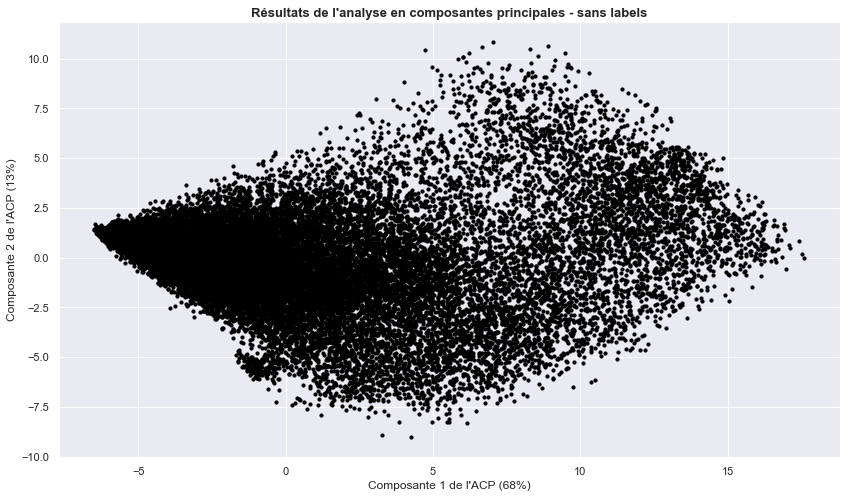

In [24]:
# Representer graphiquement les departements sur les deux premieres composante de l'acp
plt.figure(figsize = (14, 8))

plt.scatter(latent_space[:, 0], latent_space[:, 1], s = 10, color = "black")
    
plt.xlabel(f"Composante 1 de l'ACP ({acp.explained_variance_ratio_[0] * 100:.0f}%)")
plt.ylabel(f"Composante 2 de l'ACP ({acp.explained_variance_ratio_[1] * 100:.0f}%)")
plt.title("Résultats de l'analyse en composantes principales - sans labels", fontsize = 13, fontweight = "bold")
plt.show()

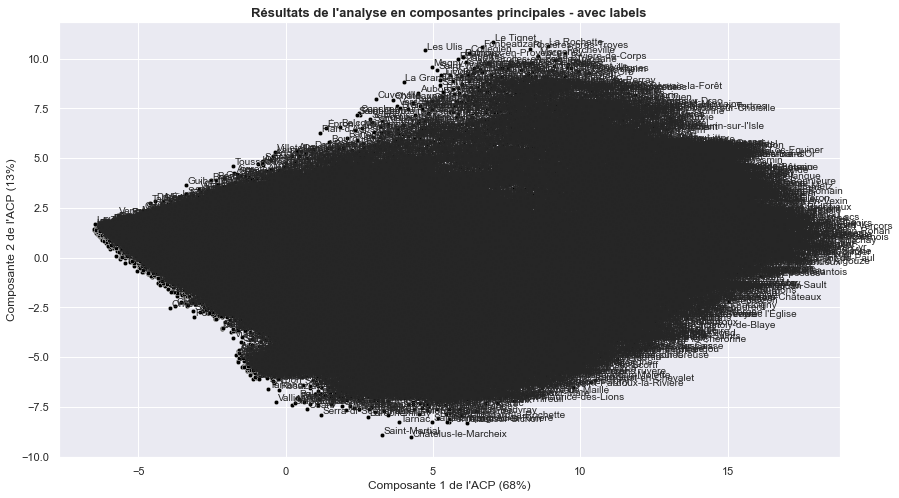

In [25]:
plt.figure(figsize = (14, 8))
sns.scatterplot(data = acp_df, x = "PC1", y = "PC2", s = 20, color = "black", marker = "o", alpha = 1, legend = None)
for i in acp_df.index:
    plt.text(acp_df["PC1"].iloc[i] + 0.05,
            acp_df["PC2"].iloc[i] + 0.05,
            acp_df["LIBGEO"].iloc[i],
            fontdict={"fontsize":10}) 
plt.xlabel(f"Composante 1 de l'ACP ({acp.explained_variance_ratio_[0] * 100:.0f}%)")
plt.ylabel(f"Composante 2 de l'ACP ({acp.explained_variance_ratio_[1] * 100:.0f}%)")
plt.title("Résultats de l'analyse en composantes principales - avec labels", fontsize = 13, fontweight = "bold")
plt.show()

## Clustering

In [26]:
# Matrice de variance-covariance des données
pd.DataFrame(np.cov(merged_df.select_dtypes(include = np.number).T), columns = merged_df.select_dtypes(include = np.number).columns, index = merged_df.select_dtypes(include = np.number).columns) 

,HT22,HT022,HT122,HT222,HT322,HT422,HT522,HTCH22,HTCH022,HTCH122,...,PTOT1926,PTOT1921,PTOT1911,PTOT1906,PTOT1901,PTOT1896,PTOT1891,PTOT1886,PTOT1881,PTOT1876
HT22,0.090364,0.0,0.0,0.0,0.0,0.0,0.0,0.840310,0.0,0.0,...,32.606480,31.326612,33.176336,32.853070,33.016910,32.459733,32.313096,32.422042,31.972633,29.985527
HT022,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HT122,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HT222,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HT322,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTOT1896,32.459733,0.0,0.0,0.0,0.0,0.0,0.0,294.276356,0.0,0.0,...,165686.469684,163997.717662,181734.741686,183693.048018,184526.910017,188850.192025,183379.112193,182353.023683,178727.103868,173442.321369
PTOT1891,32.313096,0.0,0.0,0.0,0.0,0.0,0.0,294.016039,0.0,0.0,...,162544.649521,160994.306754,178659.174150,180851.367838,182498.939094,183379.112193,187045.732694,182845.444457,179538.651571,174409.865574
PTOT1886,32.422042,0.0,0.0,0.0,0.0,0.0,0.0,292.162641,0.0,0.0,...,161047.151683,159915.672291,177217.450061,179863.196467,181613.512756,182353.023683,182845.444457,188498.927616,181527.893813,177126.480309
PTOT1881,31.972633,0.0,0.0,0.0,0.0,0.0,0.0,291.103324,0.0,0.0,...,156707.720079,155730.057095,172899.922028,175980.429745,177173.478163,178727.103868,179538.651571,181527.893813,184530.967604,176099.935993


Au vu de la matrice de variance-covariance qui n'est pas diagonale, on utilisera les GMM. Cela car le KMeans fait l'hypothèse tacite d'une matrice de variance-covariance diagonale (autrement dit, les données sont suposées distribuées selon des cercles parfaits ou des sphères et non comme des élipses).

In [27]:
from sklearn.mixture import GaussianMixture
from src.tools import find_best_k_gmm

In [28]:
# optimal_clusters = find_best_k_gmm(merged_df, columns = list(merged_df.select_dtypes(include = np.number).columns))
gmm = GaussianMixture(n_components = 5)
# 5 n'est pas optimal, mais présente de bons résultats pour un 
# nombre de clusters réduits
gmm.fit(merged_df.select_dtypes(include = float))

clusters = gmm.predict(merged_df.select_dtypes(include = np.number))

In [29]:
from src.tools import confidence_ellipse

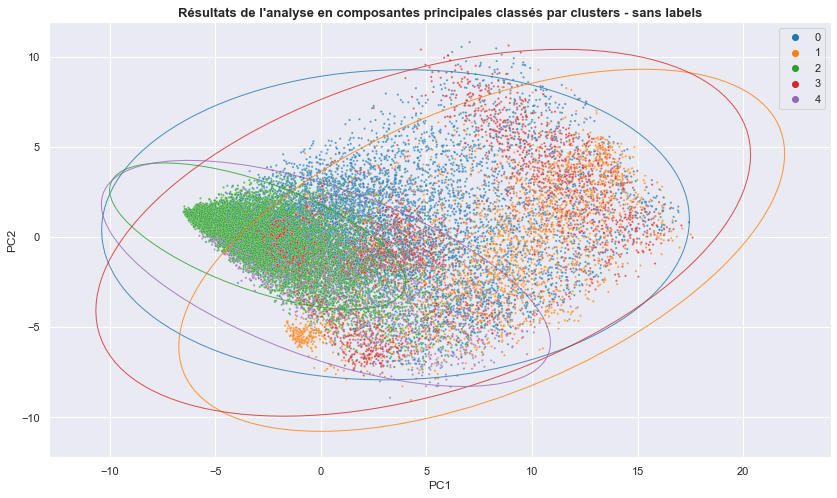

In [30]:
acp_df["Clusters"] = clusters

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(8)
plt.title(f"Résultats de l'analyse en composantes principales classés par clusters - sans labels", fontsize = 13, fontweight = "bold")
sns.scatterplot(data=acp_df, x = "PC1", y = "PC2", hue = "Clusters", s = 5, alpha = 0.7, palette = "tab10")
              
for idx, cluster in enumerate(np.sort(acp_df["Clusters"].unique())):
    confidence_ellipse(x = acp_df[acp_df["Clusters"] == cluster]["PC1"].values,
                       y = acp_df[acp_df["Clusters"] == cluster]["PC2"].values,
                       ax = ax,
                       edgecolor = plt.cm.tab10.colors[idx],
                       #facecolor = plt.cm.tab10.colors[idx],
                       alpha = .8)         
plt.legend()
plt.show()

Au vu des résultats, peut être qu'un algorithme de clustering non linéaire serait pertinent, en effet nos données vivent peut être sur une variété, un "manifold". Il semble néanmoins difficile d'identifier une structure particulière avec un algorithme linéaire.

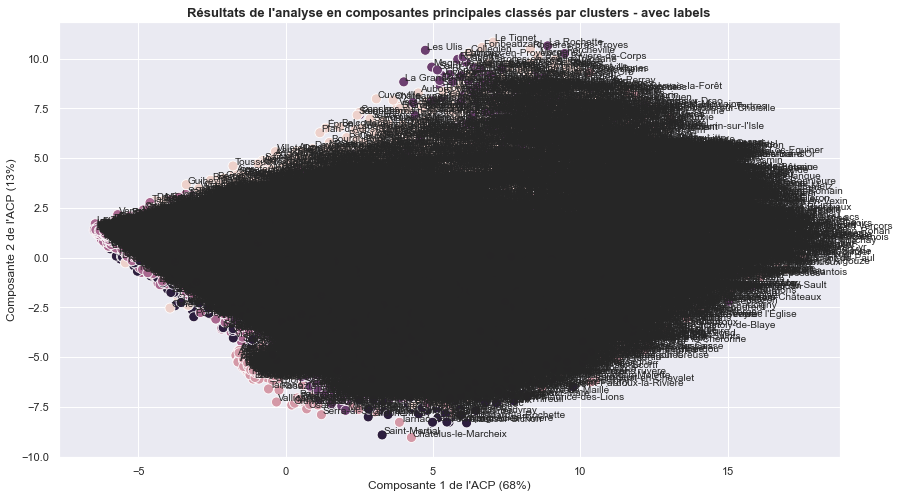

In [31]:
plt.figure(figsize = (14, 8))
sns.scatterplot(data = acp_df, x = "PC1", y = "PC2", s = 100, hue = "Clusters", marker = "o", alpha = 1, legend = None)
for i in acp_df.index:
    plt.text(acp_df["PC1"].iloc[i] + 0.05,
            acp_df["PC2"].iloc[i] + 0.05,
            acp_df["LIBGEO"].iloc[i],
            fontdict={"fontsize":10}) 
plt.xlabel(f"Composante 1 de l'ACP ({acp.explained_variance_ratio_[0] * 100:.0f}%)")
plt.ylabel(f"Composante 2 de l'ACP ({acp.explained_variance_ratio_[1] * 100:.0f}%)")
plt.title("Résultats de l'analyse en composantes principales classés par clusters - avec labels", fontsize = 13, fontweight = "bold")
plt.show()

## Machine Learning

Shape : (46584, 36)
Nombre de NaN : 11
Shape après merge : (46573, 124)
Nombre de NaN après merge : 1741256
Shape : (46573, 124)


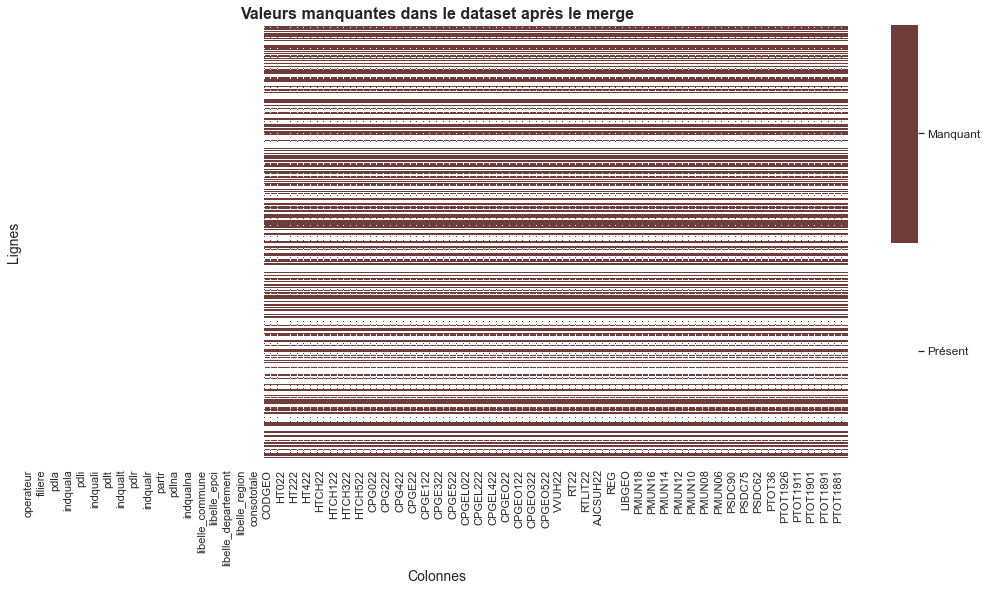

In [32]:
target_df = pd.read_csv("data/conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-commune-france.csv", low_memory=False)
print("Shape :", target_df.shape)

#target_df.loc[target_df.filiere == "Electricité", :].reset_index(drop = True, inplace = True) # Nous ne sommes interessés que par la consommation
# electrique et non celle de gaz

print(f"Nombre de NaN : {target_df.isna().sum().sum()}")
target_df.dropna(axis = 0, inplace = True)

target_df = pd.merge(target_df, merged_df, how = "left", left_on = "code_postal", right_on = "CODGEO")
print(f"Shape après merge : {target_df.shape}")
print(f"Nombre de NaN après merge : {target_df.isna().sum().sum()}")

visualize_nan(target_df, "Valeurs manquantes dans le dataset après le merge")

On cherche à prédire 3 types de consommation : la consommation électrique relative à l'agriculture "consoa", celle relative à l'industrie "consoi", et celle relative au résidentiel "consor". Nous disposons égalements de deux autres types de consommations relatives au total : "consot" et "consototale".

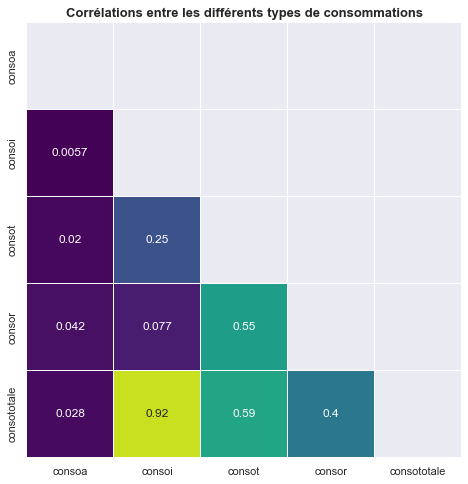

In [33]:
plt.figure(figsize = (14, 8))
plt.title(f"Corrélations entre les différents types de consommations", fontsize = 13, fontweight = "bold")
sns.heatmap(target_df.loc[:, ["consoa", "consoi", "consot", "consor", "consototale"]].corr(),
            mask = np.triu(target_df.loc[:, ["consoa", "consoi", "consot", "consor", "consototale"]].corr()),
            annot = True,
            square = True,
            linewidths=.5,
            vmin = 0,
            vmax = 1,
            cbar = False,
            cmap = "viridis")
plt.show()

Certaines corrélations sont fortement corrélées entre elles, notamment la consommation totale avec celle de l'industrie. Nous ferons ici le choix de tout garder; en effet, on peut vouloir prédire la consommation par secteur d'une ville a partir de sa consommation totale. Mais nous aurions aussi pu faire le choix d'enlever ces dernières en estimant qu'on ne dispose à priori d'aucune information vis à vis des consommations d'une commune.

In [34]:
target_df.loc[target_df.libelle_commune == "Narcy", [x for x in target_df.columns if "conso" in x or x == "filiere"]]

,filiere,consoa,consoi,consot,consor,consona,consototale
230,Electricité,0.0,0.000000,76.034030,743.251637,0.0,819.285667
833,Electricité,0.0,64.182065,295.628456,1907.552245,0.0,2267.362766
1846,Gaz,0.0,0.000000,133.777210,962.268060,0.0,1096.045270


On remarque que certaines communes apparaissent plusieurs fois (ce n'est pas le cas de toutes). Affichons les corrélations des lignes sur 10 communes dupliquées (séléctionnées aléatoirement).

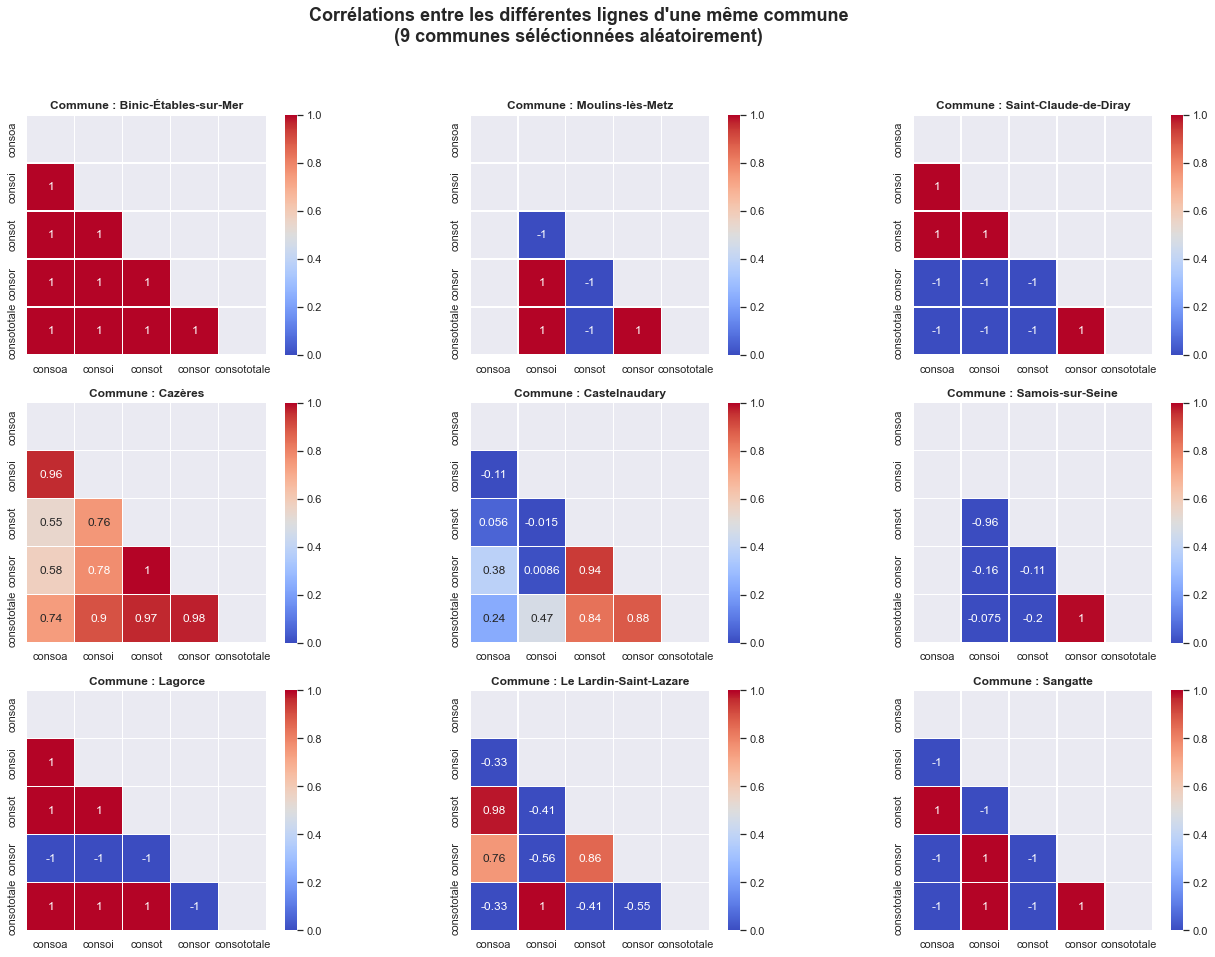

In [35]:
# Les consommations des différentes observations d'une même commune sont elles informatives ?
ncols = 3
sample_size = ncols * 3
nrows=(sample_size + ncols - 1) // ncols

fig, _ = plt.subplots(ncols=ncols, nrows=nrows, figsize=(7.5 * ncols, 5 * nrows), sharey=False)
fig.suptitle(f"Corrélations entre les différentes lignes d'une même commune\n({sample_size} communes séléctionnées aléatoirement)", 
             fontsize=18, 
             fontweight = "heavy")

for axe, commune in zip(fig.axes, target_df.loc[target_df.libelle_commune.duplicated(), "libelle_commune"].sample(sample_size)):
    axe.set_title(f"Commune : {commune}", fontweight = 'bold')
    sns.heatmap(target_df.loc[target_df.libelle_commune == commune, ["consoa", "consoi", "consot", "consor", "consototale"]].corr(),
                mask = np.triu(target_df.loc[target_df.libelle_commune == commune, ["consoa", "consoi", "consot", "consor", "consototale"]].corr()),
                annot = True,
                square = True,
                linewidths=.5,
                vmin = 0,
                vmax = 1,
                cmap = "coolwarm", 
                ax = axe)
plt.show()

On remarque que pour les observations revenants plusieurs fois, les différents types de corrélations sont très informatives les unes par rapport aux autres. Nous pourrions proposer un modèle en conséquence, scindant notre problème en 2 parties : une partie de modélisation relatives aux nouvelles villes et une partie relatives au ville déjà connues. Ici, nous nous cantonnerons à la prédiction d'un seul modèle pour l'ensemble par soucis de simplicité.

#### Split du dataset en train / test / validation

On dispose d'assez d'observation pour ne pas avoir recours à la cross-validation. Nous prenons donc un jeu de validation correspondant à 10% du train set (qui lui même représentais 2/3 des données).

A noter que l'on cherche à prédire les 3 types de consommations simultanément. La séparation du dataset se fait sans tenir compte des doublons. 

In [36]:
from sklearn.model_selection import train_test_split

y = np.array([target_df.consoi, target_df.consoa, target_df.consor]).T
X = target_df.drop(labels = ["consoi", "consoa", "consor"], axis = 1).select_dtypes(include = np.number) # On ne garde que les numériques

X.fillna(value = 0, inplace = True) # On remplace les NaN par des 0. De ce fait, les variables ou nous n'aurons pas d'informations vont être "éteintes"
# pendant l'entrainement du modèle. Nous nous permettons ce procédé de par la nature du modèle de réseau de neurones.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1)

### Ajustement du train set

In [37]:
import torch
import torch.nn as nn

Epoch 1: Train loss = 2878.7236 / Validation loss = 1115.3313
Epoch 2: Train loss = 1288.7908 / Validation loss = 940.2834
Epoch 3: Train loss = 1178.9613 / Validation loss = 925.0325
Epoch 4: Train loss = 1138.7186 / Validation loss = 911.3369
Epoch 5: Train loss = 1098.3355 / Validation loss = 1006.3997
Epoch 6: Train loss = 1122.8732 / Validation loss = 1039.7997
Epoch 7: Train loss = 1080.8374 / Validation loss = 964.9767
Epoch 8: Train loss = 1024.0131 / Validation loss = 1461.4049
Epoch 9: Train loss = 1045.2062 / Validation loss = 828.0523
Epoch 10: Train loss = 1003.0014 / Validation loss = 909.8975
Epoch 11: Train loss = 974.8965 / Validation loss = 1284.3364
Epoch 12: Train loss = 974.2251 / Validation loss = 820.7076
Epoch 13: Train loss = 973.5497 / Validation loss = 1128.3088
Epoch 14: Train loss = 963.6387 / Validation loss = 809.1920
Epoch 15: Train loss = 918.0820 / Validation loss = 780.9109
Epoch 16: Train loss = 919.4219 / Validation loss = 775.0809
Epoch 17: Train l

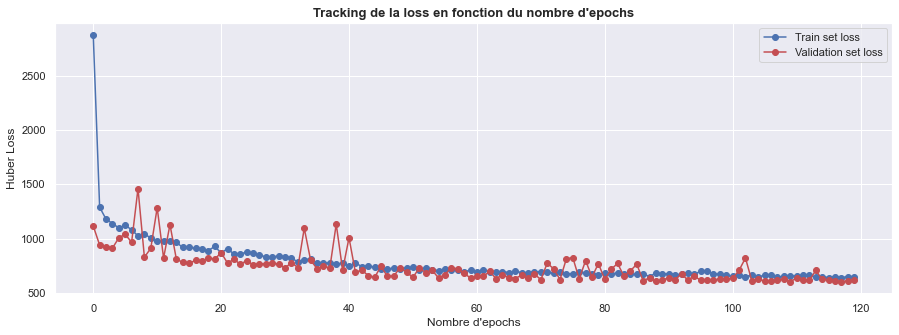

In [38]:
from src.model import NeuralNet

# On utilise un réseau dense, le code est disponible dans le script model.py
# Instanciation du modèle
input_size = X_train.shape[1]
hidden_size_1 = 2**6
hidden_size_2 = 2**4
# Le modèle est composé de 2 couches cachées (activation ReLU), une de 32 neurones et une de 8 neurones
num_outputs = y_train.shape[1]

model = NeuralNet(input_size, hidden_size_1, hidden_size_2, num_outputs)

# Define the loss function and optimizer
criterion = nn.HuberLoss(reduction="mean") # On utilise la Huber loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # On utilise Adam comme optimizer
nb_epochs = 120

fitted_model = model.fit(X_train.values, y_train, 
                                            X_val.values, y_val, 
                                            optimizer=optimizer, 
                                            loss_fn=criterion, 
                                            nb_epochs=nb_epochs)

La descente de gradient semble avoir quasiment convergée.

### Evaluation des résultats sur le test set

Pour évaluer le modèle, on calcule les métriques d'erreur classiques en régression (RMSE / MAE / R²). On ajoute à cela une mesure : la MAE/l'écart type des données, le tout en pourcentage. Cela pour mettre à l'échelle la MAE en la divisant par la mesure de dispersion de nos données.

In [39]:
from src.tools import compute_results
compute_results(y_test, fitted_model.predict(X_test.values)) # Les résultats du réseau de neurones sur le test set

,Industrie,Agriculture,Résidence
RMSE,4715.458886,1423.220263,4260.287625
MAE,884.392111,144.021318,813.313537
MAE/std en %,0.984700,9.827222,3.605926
R²,0.672826,0.672826,0.672826


Notre modèle semble bien performer sur l'industrie et les données résidencielles. En revanche, il semble un peu moins bien performer sur les données d'agriculture.